# Lecture 11. Word Embeddings and Sentiment Analysis


<img src="./figures/embedding_exp.jpg" width="500" />

## Working with text data
- Text data를 모형의 입력값으로 사용하기 위해서는 text를 숫자 vector로 표현하는 과정이 필요(vectorize)
    - Text를 word 단위로 쪼개어 각 단어를 vector로 표현 
    - Text를 character 단위로 쪼개어 각 character를 vector로 표현
    - Text를 word나 character의 "n-gram"(연속된 n개의 word나 character)으로 쪼개여 각 "n-gram"을 vector로 표현 
- Token: 텍스트를 쪼개어 만들어낸 입력 단위
- One-hot encoding 
    - Text에 총 10000개의 단어가 있다면 각 단어를 0과 1로 이루어진 $10000 \times 1$  vector로 표현 
    - Input dimension의 수가 커지기 때문에 복잡도 증가 
- Word embedding 
    - 저차원의 dense vector로 mapping하여 표현 
    

<img src="figures/w2v.PNG" width="40%" align="left">
<img src="figures/textvec.PNG" width="30%" >

 <br>   
  <br> 
   <br> 
    
<img src="https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png" width="50%" align="center">

## Word embedding

- 단어 사이의 추상적이고 기하학적인 관계를 반영하여 벡터화 하는 방법
- 동의어가 비슷한 벡터로 임베딩이 될 수 있음(벡터 간의 거리가 가까움)
- 단어 벡터 간의 방향이 의미를 내포할 수 있음 
- 단어 벡터 간의 연산이 의미를 가짐
    - man과 king의 관계 = woman과 queen의 관계 
    - king - man + woman = queen
![](https://cdn-images-1.medium.com/max/1200/1*sXNXYfAqfLUeiDXPCo130w.png)

![](https://blogs.mathworks.com/images/loren/2017/vecs.png)

## Two approaches for word embedding
1. Main task(document classification, sentiment classifiation 등)와 동시에 embedding 학습
    - Prediction 성능에 최적화된 embedding 계산
    - 단어 간의 의미상 거리가 잘 보존되지 않을 수 있음 
    - Keras의 `Embedding` layer를 통해 학습 
    
2. Embedding을 따로 학습하고 사전학습된 embedding matrix를 사용하여 main task 수행 
    - 단어 간의 의미상 거리를 보다 잘 표현하는 방법
    - Prediction 성능은 저하될 수 있음 
    - gensim의 Word2Vec을 통해 embedding을 학습한 후 keras input으로 활용 

## 11.1 Learning word embeddings with the embedding layer


### Keras embedding layer 
- Dictionary에 포함된 단어의 정수 index를 실수 벡터(dense vector)로 mapping하는 층
- `Embedding` layer의 arguments
    - `input_dim`: vocabulary의 크기. 즉, 총 vocabulary가 1000개의 단어를 포함하고 있으면 `input_dim=1000`
    - `output_dim`: Dense vector로 표현되는 embedding vector의 크기(embedding dimensionality). 64차원의 벡터로 각 단어를 표현한다면 `output_dim=64`
    - `input_length`: input data가 가지는 시퀀스의 길이. 즉, 몇 time step를 각 sample이 포함하는가? 몇 개의 단어로 하나의 입력문장이 이루어져 있는가?output_dim
    

- `Embedding` layer에 입력되는 데이터의 shape = `(samples, input_length)`
    - 단어의 index를 포함하는 array
    - 단어 10개로 이루어진 문장이 32개 포함된 batch일 경우 (32, 10) 
    - 모든 sequence는 같은 길이어야 함. (같은 사이즈의 np.array를 입력받음)
        - 만일 길이가 짧다면 0을 넣어 길이를 동일하게 맞추어 줌 


- `Embedding` layer의  Output shape =  `(samples, input_length, output_dim)` 
    - RNN의 input으로 사용 가능 




In [1]:
from keras.layers import Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(1000, 64, input_length=20))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 64)            64000     
Total params: 64,000
Trainable params: 64,000
Non-trainable params: 0
_________________________________________________________________


- $(1000 \times 1)$ one-hot vector를 $(64 \times 1)$ dense vector로 변환
- 단어 20개로 이루어진 문장을 단어 index로 표현하여 입력하면 각 단어가 $(64 \times 1)$ dense vector로 표현된 결과로 출력됨

### Example: Sentiment analysis for movie review
- 영화리뷰 문장이 긍정/부정인지 판단하는 모형 
- Input = “The Da Vinci Code book is just awesome.”
- Output = 1 (긍정)
- 한 문장의 각 단어를 매 시점의 input으로 사용 
- 매 단어(시점)마다 긍/부정의 답이 필요하지 않으므로 마지막 시점에 대한  output만을 사용: many-to-one 구조
<img src="figures/sentiment.png" width="40%">
(umich-sentiment-train.txt)

        1	The Da Vinci Code book is just awesome.
        1	this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this.
        1	i liked the Da Vinci Code a lot.
        1	i liked the Da Vinci Code a lot.
        1	I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.
        1	that's not even an exaggeration ) and at midnight we went to Wal-Mart to buy the Da Vinci Code, which is amazing of course.
        1	I loved the Da Vinci Code, but now I want something better and different!..
        ...


#### Data preprocessing


In [2]:
MAX_FEATURES = 2000   
MAX_SENTENCE_LENGTH = 40  

- `MAX_FEATURES = 2000`: 최대 2000개의 단어를 사용하여 dictionary 구성  
- `MAX_SENTENCE_LENGTH = 40`: 문장의 최대 길이을 40개 단어로 제한 

- NLTK 자연어 처리 패키지
- 주요 기능
  - 말뭉치
  - 토큰 생성
  - 형태소 분석
  - 품사 태깅

In [3]:
import collections
import os 
import nltk
nltk.download('punkt')

maxlen = 0
word_freqs = collections.Counter() # 컨테이너에 동일한 값의 자료가 몇개인지를 파악하는데 사용하는 객체
num_recs = 0
ftrain = open("data/umich-sentiment-train.txt", 'rb')
for line in ftrain:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    #print(words)
    if len(words) > maxlen:
        maxlen = len(words)  # the maximum number of words in a sentence
    for word in words:
        word_freqs[word] += 1  # frequency for each word
    num_recs += 1 # total number of records
ftrain.close()

print(word_freqs)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\028\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Counter({'i': 4707, ',': 4194, '.': 3364, 'the': 3221, 'and': 2150, '!': 2131, 'potter': 2093, 'harry': 2088, 'vinci': 2001, 'da': 1998, 'brokeback': 1996, 'code': 1994, 'mountain': 1994, 'love': 1542, 'is': 1521, '...': 1441, 'a': 1305, 'was': 1179, '..': 1153, 'awesome': 1126, 'impossible': 1091, 'mission': 1090, 'like': 974, 'it': 899, 'to': 808, 'movie': 783, 'that': 718, "'s": 629, 'because': 608, 'sucks': 601, 'sucked': 596, 'hate': 578, 'so': 506, 'as': 473, 'my': 462, 'much': 452, '``': 449, 'of': 424, 'really': 374, 'movies': 366, 'stupid': 365, 'you': 330, 'down': 322, 'but': 295, 'we': 295, 'be': 290, 'with': 288, 'just': 287, 'one': 283, 'know': 276, 'suck': 276, '3': 271, 'out': 269, 'who': 263, '/': 263, 'or': 263, 'am': 259, 'loved': 256, 'want': 254, 'into': 253, 'which': 251, 'right': 249, 'for': 241, 'an': 225, "n't": 224, 'this': 213, 'me': 213, ':': 207, 'are': 203, 'think': 202, 'not': 198, 'how': 197, 'if': 195, '....': 190, 'depressing': 188, 'people': 183, 'his'

- collections.Counter: dict의 subclass로 요소들의 개수 저장
- 단어의 출현 빈도를 계산 

In [4]:
maxlen, len(word_freqs)

(42, 2268)

- 총 2328개의 단어가 포함되어 있음
- 가장 긴 문장이 42개의 단어로 구성됨 

----
##### --- Practice line-by-line ---

In [5]:
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open("data/umich-sentiment-train.txt", 'rb')

In [6]:
line = b'1\tThe Da Vinci Code book is just awesome.\n'
label, sentence = line.decode('utf8').strip().split("\t")

In [7]:
label

'1'

In [8]:
sentence.lower()

'the da vinci code book is just awesome.'

In [9]:
words = nltk.word_tokenize(sentence.lower())

In [10]:
words

['the', 'da', 'vinci', 'code', 'book', 'is', 'just', 'awesome', '.']

In [11]:
for word in words:
    word_freqs[word] += 1 

In [12]:
word_freqs

Counter({'the': 1,
         'da': 1,
         'vinci': 1,
         'code': 1,
         'book': 1,
         'is': 1,
         'just': 1,
         'awesome': 1,
         '.': 1})

In [13]:

maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open("data/umich-sentiment-train.txt", 'rb')
for line in ftrain:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
        maxlen = len(words)  # the maximum number of words in a sentence
    for word in words:
        word_freqs[word] += 1  # frequency for each word
    num_recs += 1 # total number of records
ftrain.close()

----

In [14]:
# 1 is UNK, 0 is PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0   # for sentences shorter than MAX_SENTENCE_LENGTH
word2index["UNK"] = 1   # for words not in the vocabulary
index2word = {v:k for k, v in word2index.items()}

- `word2index`: 단어를 index로 mapping하는 dictionary
- `index2word`: index를 단어로 mapping하는 dictionary
- `"PAD"`: 입력 데이터의 차원을 동일하게 만들기 위해 문장의 길이가 MAX_SENTENCE_LENGTH보다 짧을 경우 `"PAD"`를 채워줌 (index=0)
- `"UNK"`: dictionary에 포함되지 않은 단어는 `"UNK"`으로 입력

#### Construct dataset

In [15]:
import numpy as np 
from keras.preprocessing import sequence

X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open("data/umich-sentiment-train.txt", 'rb')

for line in ftrain:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

In [16]:
X[0]

[5, 11, 10, 13, 101, 16, 49, 21, 4]

In [17]:
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [18]:
X[0]


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   5,  11,  10,  13, 101,  16,  49,  21,
         4])

- 문장을 단어의 index로 변환하여 list로 생성
- 문장의 길이가 `MAX_SENTENCE_LENGTH`보다 작으면 0으로 padding 


#### Train/test data split

In [19]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


#### Building and fitting a model

In [20]:
BATCH_SIZE = 512
NUM_EPOCHS = 100
EMBEDDING_SIZE = 128

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH, mask_zero = True))
model.add(LSTM(32, recurrent_dropout=0.2, return_sequences = False, activation = 'relu'))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 276,897
Trainable params: 276,897
Non-trainable params: 0
_________________________________________________________________


- `vocab_size` 크기의 dictionary로 표현된 input을 EMBEDDING_SIZE로 표현 
- `input_length=MAX_SENTENCE_LENGTH`: 뒤이어 연결되는 recurrent layer에 입력을 위한 순차적인 입력단어의 수 
- `mask_zero = True`: 0으로 padding 한 부분을 학습시 사용하지 않음 

In [22]:
import time 

now = time.strftime("%c")
callbacks_list = [
    ModelCheckpoint(filepath='logs/sentiment_analysis.h5', monitor='val_loss', save_best_only=True),
    TensorBoard(log_dir='logs/sentiment_analysis', histogram_freq=1, embeddings_freq=1,
               profile_batch=100000000),
    # histogram_freq=1 : 1 에포크마다 활성화 출력의 히스토그램을 기록
    # embeddings_freq=1 : 1에포크 마다 임베딩 데이터 기록
    EarlyStopping(monitor='val_loss',patience=3)
]
model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, ytest), callbacks=callbacks_list)

C:\Users\028\anaconda3\lib\site-packages\keras\callbacks\tensorboard_v2.py:102: UserWarning: The TensorBoard callback does not support embeddings display when using TensorFlow 2.0. Embeddings-related arguments are ignored.
  warnings.warn('The TensorBoard callback does not support '
C:\Users\028\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 5668 samples, validate on 1418 samples
Epoch 1/100
5668/5668 [==============================] - 2s 279us/step - loss: 0.6831 - acc: 0.5873 - val_loss: 0.6674 - val_acc: 0.6848
Epoch 2/100
5668/5668 [==============================] - 1s 199us/step - loss: 0.6470 - acc: 0.7064 - val_loss: 0.6089 - val_acc: 0.7370
Epoch 3/100
5668/5668 [==============================] - 1s 194us/step - loss: 0.5442 - acc: 0.7618 - val_loss: 0.4357 - val_acc: 0.8251
Epoch 4/100
5668/5668 [==============================] - 1s 187us/step - loss: 0.9187 - acc: 0.8986 - val_loss: 0.3647 - val_acc: 0.9295
Epoch 5/100
5668/5668 [==============================] - 1s 179us/step - loss: 0.3233 - acc: 0.9323 - val_loss: 0.2756 - val_acc: 0.9351
Epoch 6/100
5668/5668 [==============================] - 1s 181us/step - loss: 0.2335 - acc: 0.9439 - val_loss: 0.1995 - val_acc: 0.9478
Epoch 7/100
5668/5668 [==============================] - 1s 176us/step - loss: 0.2379 - acc: 0.9513 - val_loss: 0.1715 - val_acc: 

In [23]:
model.save('logs/sentiment_analysis.h5')

In [24]:
from keras.models import load_model

model=load_model('logs/sentiment_analysis.h5')
model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)

1418/1418 [==============================] - 0s 101us/step


[0.03429427678855754, 0.9866008758544922]

#### Prediction for test sentences

In [25]:
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1	1	i love being a sentry for mission impossible and a station for bonkers .
1	1	anyway , thats why i love `` brokeback mountain .
0	0	friday hung out with kelsie and we went and saw the da vinci code sucked ! ! ! ! !
0	0	combining the opinion / review from gary and gin zen , the da vinci code sucks .
1	1	man i loved brokeback mountain !


***
## 11.2 Using pre-trained word embeddings

- 풀고자 하는 main task와 함께 word embedding을 학습하는 대신 미리 계산된 embedding 공간에서 vector를 로드하여 사용
- 충분한 데이터로 학습한 embedding vector는 언어구조의 일반적인 측면을 잡아낼 수 있음
- Word embedding을 계산하는 알고리즘
    - Word2vec(skip-gram, CBow)
    - GloVe
    - Fasttext
    - ELMo
    - BERT

###  Word2Vec with Gensim

- Word2Vec (Mikolov in Google, 2013)
- Skipgram: 문장에서 중심 단어들로 주변에 위치한 단어들의 출현을 예측하는 알고리즘
<img src="http://i.imgur.com/TupGxMl.png" width="50%" align="left" >
<img src="http://i.imgur.com/8zNRwsn.png" width="50%" >

- word2vec으로 학습 된 embedding matrix를 keras의 embedding layer에 넣어 prediction model 학습
- Input: 단어들로 이루어진 list 

In [26]:
## Toy example
input_text = [['the', 'da', 'vinci', 'code', 'book', 'is', 'just', 'awesome', '.'],
              ['i', 'liked', 'the', 'da', 'vinci', 'code', 'a', 'lot', '.']]

In [27]:
!conda install gensim

Solving environment: ...working... done

# All requested packages already installed.



In [28]:
from gensim.models import Word2Vec
#embed_model = Word2Vec(input_text, sg=1, window=5, min_count=1)
embed_model = Word2Vec(input_text, sg=1, size=5, window=5, min_count=1)

- `sg=1`: skipgram 알고리즘 사용 
- `size=5`: embedding size 
- `window=5`: 주변의 5개 단어를 사용하여 해당 단어의 출현 예측 
- `min_count=1`: 최소 1번 이상 출현한 단어들만 사용 (default=5)

#### Preparing data for Word2Vec

In [29]:
vocab = [v for v, _ in word_freqs.most_common(MAX_FEATURES)]

sentences = np.empty((num_recs, ), dtype=list)
i = 0
ftrain = open("data/umich-sentiment-train.txt", 'rb')

for line in ftrain:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    sentence = []
    for word in words:
        if word in vocab:
            sentence.append(word)
        else:
            sentence.append("UNK")
    sentences[i] = sentence
    i += 1
    
ftrain.close()

sentences=list(sentences)

In [30]:
len(sentences)

7086

In [31]:
sentences[0]

['the', 'da', 'vinci', 'code', 'book', 'is', 'just', 'awesome', '.']

- 문장을 단어로 쪼개어 단어로 이루어진  list로 변환 

#### Word2Vec by gensim 

In [32]:
from gensim.models import Word2Vec
embed_model = Word2Vec(sentences, sg=1, size=EMBEDDING_SIZE, window=5, min_count=1)

In [33]:
embed_model.wv.index2word

['i',
 ',',
 '.',
 'the',
 'and',
 '!',
 'potter',
 'harry',
 'vinci',
 'da',
 'brokeback',
 'code',
 'mountain',
 'love',
 'is',
 '...',
 'a',
 'was',
 '..',
 'awesome',
 'impossible',
 'mission',
 'like',
 'it',
 'to',
 'movie',
 'that',
 "'s",
 'because',
 'sucks',
 'sucked',
 'hate',
 'so',
 'as',
 'my',
 'much',
 '``',
 'of',
 'really',
 'movies',
 'stupid',
 'you',
 'down',
 'but',
 'we',
 'be',
 'with',
 'just',
 'one',
 'know',
 'suck',
 '3',
 'out',
 'UNK',
 'who',
 '/',
 'or',
 'am',
 'loved',
 'want',
 'into',
 'which',
 'right',
 'for',
 'an',
 "n't",
 'this',
 'me',
 ':',
 'are',
 'think',
 'not',
 'how',
 'if',
 '....',
 'depressing',
 'people',
 'his',
 'would',
 'horrible',
 'up',
 'reading',
 'why',
 'series',
 'there',
 'in',
 'only',
 'fucking',
 'terrible',
 'she',
 'oh',
 'story',
 'being',
 'left',
 'ok',
 'guy',
 'here',
 'start',
 'felicia',
 '(',
 'book',
 'have',
 'about',
 'beautiful',
 'good',
 'too',
 'also',
 'do',
 'on',
 'went',
 'read',
 'at',
 'then',


In [34]:
embed_model.save('embed_model.model')
embed_model.most_similar('horrible')

<ipython-input-34-51a12bfb6e99>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  embed_model.most_similar('horrible')


[('such', 0.9520995616912842),
 ('ok', 0.8805176019668579),
 ('fucking', 0.8642287254333496),
 ('pretty', 0.8005291223526001),
 ('boring', 0.7800683379173279),
 ('shitty', 0.762804388999939),
 ('terrible', 0.7506769895553589),
 ('omg', 0.7477649450302124),
 ('actually', 0.7406018376350403),
 ('film', 0.7383289337158203)]

#### Extract embedding matrix 

In [35]:
embedding_matrix = embed_model.wv.vectors

In [36]:
embedding_matrix.shape

(2001, 128)

- Word2vec 학습 시 padding은 고려하지 않았기 때문에 vocabulary size = 2001
- keras의 embedding layer에 입력할 때 padding('0')을 사용하므로 embedding matrix의 첫 행에 padding에 대한 weight를 0으로 추가

In [37]:
embedding_matrix = np.append(np.zeros((1,EMBEDDING_SIZE)), embedding_matrix, axis=0)

In [38]:
embedding_matrix.shape

(2002, 128)

- Prediction model에서 사용하기 위해 embedding matrix를 저장 
- 2000개 단어 + "UNK"를 128 차원의 dense vector로 mapping 하는 행렬

#### Construct input and outputs for prediction models

In [39]:
index2word = {i+1: w for i, w in enumerate(embed_model.wv.index2word)} 
index2word[0] = 'PAD'
word2index = {w: i for i, w in index2word.items() }

In [40]:
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open("data/umich-sentiment-train.txt", 'rb')

for line in ftrain:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [41]:
X.shape

(7086, 40)

- Keras를 사용한 prediction model의 첫 layer에 Embedding layer를 사용하므로 embedding layer의 input data 형태인 단어의 index로 구성된 list로 데이터 변환 


#### Building and fitting a model 

In [42]:
BATCH_SIZE = 512
NUM_EPOCHS = 100
EMBEDDING_SIZE = 128

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length = MAX_SENTENCE_LENGTH, mask_zero = True,
                    weights = [embedding_matrix], trainable = False)) 

model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences = False, activation = 'relu'))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 276,897
Trainable params: 20,641
Non-trainable params: 256,256
_________________________________________________________________


- Embedding layer의 옵션

    - `weights = [embedding_matrix]`: 사전에 학습된 embedding matrix을 사용
    - `trainable = False`: embedding layer의 weight를 학습시키지 않고 주어진 embedding matrix 값으로 고정 
    - `mask_zero` : 어디가 패딩한 부분이고, 어디가 의미가 존재하는지를 알려줌<br> https://wiserloner.tistory.com/1061

In [44]:
#now = time.strftime("%c")
now = time.strftime('%Y-%m-%d', time.localtime(time.time()))
callbacks_list = [
    ModelCheckpoint(filepath='logs/sentiment_analysis_w2v.h5', monitor='val_loss', save_best_only=True),
    TensorBoard(log_dir='logs/sentiment_analysis_w2v/'+now),
    EarlyStopping(monitor='val_loss',patience=3)
]
model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, ytest), callbacks=callbacks_list)

Train on 5668 samples, validate on 1418 samples
Epoch 1/100
2048/5668 [=========>....................] - ETA: 1s - loss: 0.6908 - acc: 0.5376

C:\Users\028\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:92: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208071). Check your callbacks.
  warnings.warn(


5668/5668 [==============================] - 2s 312us/step - loss: 0.6674 - acc: 0.5868 - val_loss: 0.6315 - val_acc: 0.6700
Epoch 2/100
5668/5668 [==============================] - 1s 151us/step - loss: 0.5964 - acc: 0.7085 - val_loss: 0.5398 - val_acc: 0.7447
Epoch 3/100
5668/5668 [==============================] - 1s 164us/step - loss: 0.5096 - acc: 0.7685 - val_loss: 0.4452 - val_acc: 0.7849
Epoch 4/100
5668/5668 [==============================] - 1s 148us/step - loss: 0.4284 - acc: 0.8065 - val_loss: 0.3621 - val_acc: 0.8702
Epoch 5/100
5668/5668 [==============================] - 1s 157us/step - loss: 0.3552 - acc: 0.8649 - val_loss: 0.2968 - val_acc: 0.9006
Epoch 6/100
5668/5668 [==============================] - 1s 144us/step - loss: 0.2970 - acc: 0.8867 - val_loss: 0.2372 - val_acc: 0.9055
Epoch 7/100
5668/5668 [==============================] - 1s 145us/step - loss: 0.2564 - acc: 0.9056 - val_loss: 0.2060 - val_acc: 0.9090
Epoch 8/100
5668/5668 [==============================

In [45]:
loss_test, acc_test = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test loss: %.3f, accuracy: %.3f" % (loss_test, acc_test))

1418/1418 [==============================] - 0s 62us/step
Test loss: 0.051, accuracy: 0.977


#### Prediction for test sentences

In [55]:
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1	1	, is vinci ... the
1	1	, want movie be here sucks , is vinci ... . ! , movies want was place where people take to serious . but to a still as of fun the
1	1	, is impossible awesome . to because it and only action that , it . plus tom cruise a in to the
1	1	, . too . it vinci potter..
0	0	brokeback da mountain hate the


#### Visualize word embedding using t-SNE

- Embedding 결과 단어 간의 의미 상 거리를 보존하는지 2차원 평면에서 확인 
- t-SNE를 통해 `EMBEDDING_SIZE` 차원의 행렬을 2차원으로 표현 

In [46]:
from sklearn.manifold import TSNE
#from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

model = TSNE(learning_rate=100)
transformed = model.fit_transform(embedding_matrix)

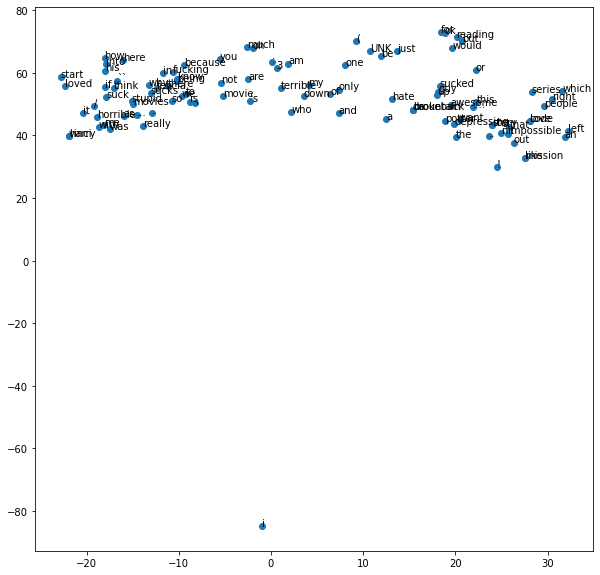

In [47]:
TOPN=100

fig = plt.figure(figsize=(10,10))
plt.scatter(transformed[:TOPN, 0], transformed[:TOPN, 1])

words = list(index2word.values())[:TOPN]
for i, word in enumerate(words):
    plt.annotate(word, xy=(transformed[i, 0], transformed[i, 1]))
plt.show()